In [1]:
# Homework 6 Template
# G. Besla & R. Li

In [112]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G
from numpy.linalg import norm

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams

%matplotlib inline

In [3]:
# my modules
from galaxy.galaxy import Galaxy
# Step 1: modify CenterOfMass so that COM_P now takes a parameter specifying 
# by how much to decrease RMAX instead of a factor of 2
from galaxy.centerofmass import CenterOfMass

Start by finding out what we're dealing with in terms of particle numbers:

In [4]:
from galaxy.galaxies import Galaxies

g_small = Galaxies(datadir='./VLowRes')
g_small.get_counts_pivot()

typename,1 Halo,2 Disk,3 Bulge,All
name,,,,
M31,25000,60000,9500,94500
M33,5000,9300,0,14300
MW,25000,37500,5000,67500
All,55000,106800,14500,176300


In [84]:
def orbit_com(galname, start, end, n, datadir='.', show_progress=True):
    """
    function that loops over all the desired snapshots to compute the COM pos and vel as a function of time.
    inputs:
          
    returns: 
    """
    
    # compose the filename for output
    fileout = f'./orbit_{galname}.txt'
    
    #  set tolerance and vol_dec for calculating COM_P in CenterOfMass
    # for M33 that is stripped more, use different values for vol_dec
    if galname == 'M33':
        delta = 0.1
        vol_dec = 4
    else:
        delta = 0.2
        vol_dec = 2
    
    # generate the snapshot id sequence 
    # it is always a good idea to also check if the input is eligible (not required)
    snap_ids = np.arange(start, end, n)
    
    # initialize the array for orbital info: t, x, y, z, vx, vy, vz of COM
    orbit = np.zeros((len(snap_ids), 7))
    
    print(galname)
    
    for  i, snap in enumerate(snap_ids): # loop over files
        gal = Galaxy(galname, snap, datadir=datadir)
        
        # Initialize an instance of CenterOfMass class, using disk particles
        com = CenterOfMass(gal)

        # Store the COM pos and vel. Remember that now COM_P required VolDec
        com_p = com.com_p(delta, vol_dec)
        com_v = com.com_v(com_p)
    
        # store the time, pos, vel in ith element of the orbit array,  without units (.value) 
        orbit[i] = gal.time.value/1000, *tuple(com_p.value), *tuple(com_v.value)
        
        # print snap_id to see the progress
        if show_progress:
            print(snap, end=' ')
    print('\nDone')
        
    # write the data to a file
    # we do this because we don't want to have to repeat this process 
    # this code should only have to be called once per galaxy.
    np.savetxt(fileout, orbit, fmt = "%11.3f"*7, comments='#',
               header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                      .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))

In [85]:
galnames = ('MW', 'M31', 'M33')

In [86]:
# Recover the orbits and generate the COM files for each galaxy
# read in 800 snapshots in intervals of n=5

for galname in galnames:
    gal = Galaxy('M33', datadir='./VLowRes')
    com = CenterOfMass(gal)
    orbit_com(galname, 0, 800, 1, datadir='./VLowRes')

MW
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [92]:
# Read in the data files for the orbits of each galaxy that you just created
# headers:  t, x, y, z, vx, vy, vz
# using np.genfromtxt

orbits = {}
pos = {}
vel = {}
for galname in galnames:
    fname = f'./orbit_{galname}.txt'
    with open(fname) as file:
        orbits[galname] = np.genfromtxt(fname, dtype=None, names=True)
    pos[galname] = np.array([orbits[galname][xi] for xi in ('x','y','z')])
    vel[galname] = np.array([orbits[galname][vxi] for vxi in ('vx','vy','vz')])    
elapsed_time = orbits['M33']['t']

In [105]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  

def vec_diff(vec1, vec2, axis=None):
    if axis is None:
        assert len(vec1) == len(vec2)
        return norm(vec1 - vec2)
    else:
        assert vec1.shape == vec2.shape
        return norm(vec1 - vec2, axis=axis)

In [106]:
# Determine the magnitude of the relative position and velocities 

# of MW and M31
pos_MW_M31 = vec_diff(pos['MW'], pos['M31'], axis=0)
vel_MW_M31 = vec_diff(vel['MW'], vel['M31'], axis=0)

# of M33 and M31
pos_M33_M31 = vec_diff(pos['M33'], pos['M31'], axis=0)
vel_M33_M31 = vec_diff(vel['M33'], vel['M31'], axis=0)

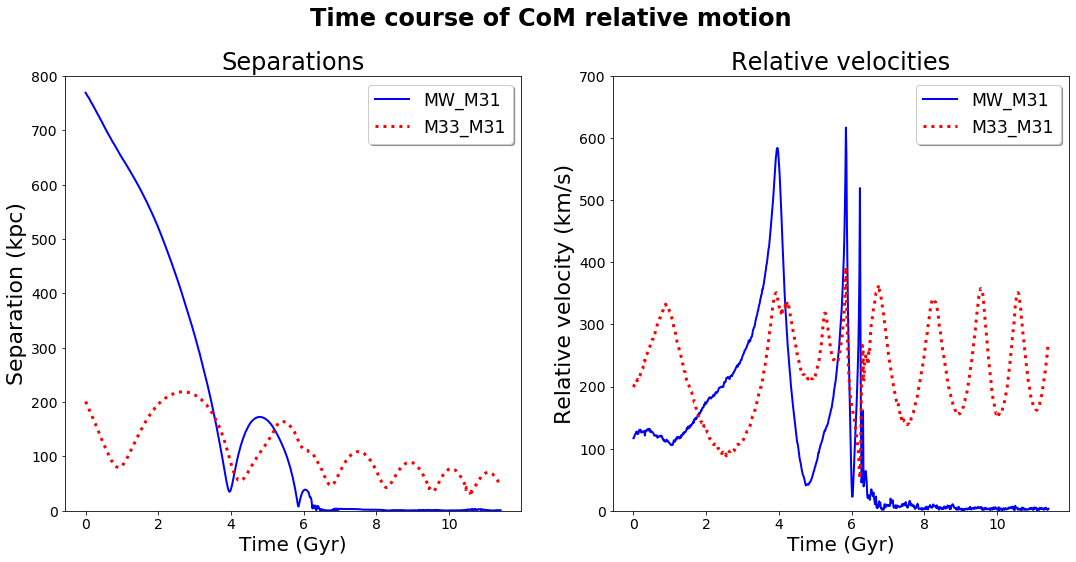

In [123]:
# Plot the Orbit of the galaxies 
#################################

fig = plt.figure(figsize=(18,8))
subplots = (121, 122)

# set up the left subplot
ax0 = plt.subplot(121)

# add the curves
ax0.plot(elapsed_time, pos_MW_M31, 'b-', lw=2, label='MW_M31')
ax0.plot(elapsed_time, pos_M33_M31, 'r:', lw=3, label='M33_M31')

# Add labels and subplot title
ax0.set_xlabel('Time (Gyr)', fontsize=20)
ax0.set_ylabel('Separation (kpc)', fontsize=22)
ax0.legend(loc='upper right',fontsize='xx-large', shadow=True)
ax0.set_title('Separations', fontsize=24)

#set axis limits
ax0.set_ylim(0, 800)

# set up the right subplot
ax1 = plt.subplot(122)

# add the curves
ax1.plot(elapsed_time, vel_MW_M31, 'b-', lw=2, label='MW_M31')
ax1.plot(elapsed_time, vel_M33_M31, 'r:', lw=3, label='M33_M31')

#adjust tick label font size
label_size = 14
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax1.set_xlabel('Time (Gyr)', fontsize=20)
ax1.set_ylabel('Relative velocity (km/s)', fontsize=22)
ax1.legend(loc='upper right',fontsize='xx-large', shadow=True)
ax1.set_title('Relative velocities', fontsize=24)

#set axis limits
ax1.set_ylim(0, 700)

# Overall title
fig.suptitle(f'Time course of CoM relative motion', y=1.0, fontsize=24, weight='bold');

In [125]:
import pandas as pd
import plotly.express as px

In [149]:
MW_M31 = pd.DataFrame()
MW_M31['t_Gyr'] = elapsed_time
MW_M31['sep_kpc'] = pos_MW_M31
MW_M31['vel_km_s'] = vel_MW_M31
MW_M31['x_sep_kpc'] = orbits['M33']['x'] - orbits['MW']['x']
MW_M31['y_sep_kpc'] = orbits['M33']['y'] - orbits['MW']['y']
MW_M31['z_sep_kpc'] = orbits['M33']['z'] - orbits['MW']['z']

In [161]:
d = px.line(MW_M31, x='t_Gyr', y='sep_kpc')
d.update_layout(
    title="M31 relative to MW, separation vs time",
    font=dict(size=16)
)
d.show()

In [160]:
MW_M31_late = MW_M31[MW_M31['t_Gyr']>3.5]
d2 = px.scatter_3d(MW_M31_late, x='x_sep_kpc', y='y_sep_kpc', z='z_sep_kpc', color='t_Gyr',
                 width=800, height=800)
d2.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
d2.update_layout(
    title="M31 relative to MW, colored by elapsed time (>3.5 Gyr)",
    font=dict(size=16)
)

d2.show()

In [159]:
d3 = px.scatter_3d(MW_M31_late, x='x_sep_kpc', y='y_sep_kpc', z='z_sep_kpc', color='sep_kpc',
                 width=800, height=800)
d3.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
d3.update_layout(
    title="M31 relative to MW, colored by separation distance",
    font=dict(size=16)
)

d3.show()